# HR Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
emp = pd.read_csv('employees.csv')

In [3]:
emp.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,dept,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


We will classify the best employees or **Top Performers** as those with evaluations that are 1 standard deviation above the mean evaluation. We will compare them against everyone else.

We could also say that the "best" employees are those with an evaluation in the top quartile (0.87 evaluation and up) but let's stick into having just two classifications for a clearer analysis.

The analysis will focus on 4 points:
- Top Performers who left the company
- Top Performers who stayed with the company
- Lower Performers who left the company
- Lower Performers who stayed with the company

## Finding the good performers

In [4]:
avg_evaluation = emp['last_evaluation'].mean()
std_evaluation = emp['last_evaluation'].std()
emp['std_performance'] = (emp['last_evaluation'] - avg_evaluation) / std_evaluation
emp['performance_differential'] = emp['last_evaluation']-(avg_evaluation+std_evaluation)
#emp

In [5]:
def performance_classification(row):
    if row['performance_differential']>=0:
        performance_class = 'Top Performer'
    else:
        performance_class = 'Lower Performer'
    return (performance_class)
emp['classification'] = emp.apply(performance_classification, axis=1)

## Calculating Average Daily Hours as a Better Indicator work-life balance
### *Assuming an average of 22 working days per month*

In [6]:
emp['daily_hours'] = emp['average_montly_hours']/22
#emp

## Prepping for Pivot Table

**ie, isolating non-numeric values (such as performance classification AND left or stayed) for averaging numerical values across them**

In [7]:
left_dict = {1: 'left', 0: 'stayed'}

emp['left(as_string)'] = (emp['left'].map(left_dict))

*keeping numeric columns only*

In [8]:
# Salary is an important indicator but since it is not numeric we will have to map the three classes of salaries
# to arbitrary numbers as shown below

salary_num_dict = {'low':30000, 'medium':60000, 'high':90000}
emp['salary_num'] = (emp['salary'].map(salary_num_dict))

numeric_columns = emp._get_numeric_data()

new_emp = emp

new_emp['performance_group'] = new_emp['left(as_string)'] + ':' + new_emp['classification']

num_pivot = new_emp.pivot_table(index='performance_group',values = numeric_columns, aggfunc='mean')
num_pivot = num_pivot.transpose()

num_pivot

performance_group,left:Lower Performer,left:Top Performer,stayed:Lower Performer,stayed:Top Performer
Work_accident,0.050988,0.038425,0.175504,0.172983
average_montly_hours,187.898024,254.862632,198.254872,202.358003
daily_hours,8.540819,11.584665,9.011585,9.198091
last_evaluation,0.623660,0.947666,0.660180,0.941899
left,1.000000,1.000000,0.000000,0.000000
number_project,3.310672,5.179635,3.777137,3.825680
performance_differential,-0.263611,0.060395,-0.227091,0.054628
promotion_last_5years,0.007115,0.000961,0.026347,0.025858
salary_num,42557.312253,42161.383285,49721.284703,48738.296924
satisfaction_level,0.399787,0.538069,0.663585,0.680013


The first thing to notice is that top performers who left had on average done more projects than any of the 3 other groups of employees **AND** have worked 52 more hours than those who stayed. 

My initial thoughts indicate that Top Performers who left were overworked, by taking on more project and working longer hours, but stayed longer at the company in the hopes of a promotion that never came. On average, their salaries were not the highest indicating that they were **underappreciated** by their managers.

Also, top performers stayed, on average, for a longer period of time at the company than the other 3 groups.

Top performers who stayed or **haven't left yet** are almost 10 times more likely to receive a promotion.

## Who works most?

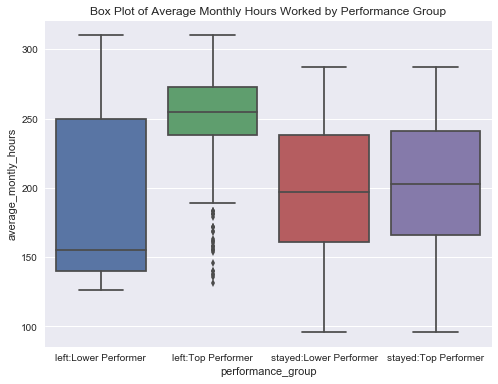

In [9]:
plt.figure(figsize=(8,6))
sns.boxplot(x='performance_group',y='average_montly_hours',data=new_emp)
plt.title('Box Plot of Average Monthly Hours Worked by Performance Group')
plt.show()

The above boxplot illustrates how top performer employees worked much harder than the rest.

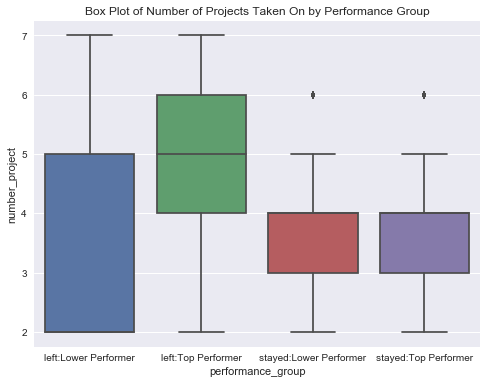

In [10]:
plt.figure(figsize=(8,6))
sns.boxplot(x='performance_group',y='number_project',data=new_emp)
plt.title('Box Plot of Number of Projects Taken On by Performance Group')
plt.show()

Here also, the top performers who left the company were more likely to take on projects.

## How much were the employees who left making?

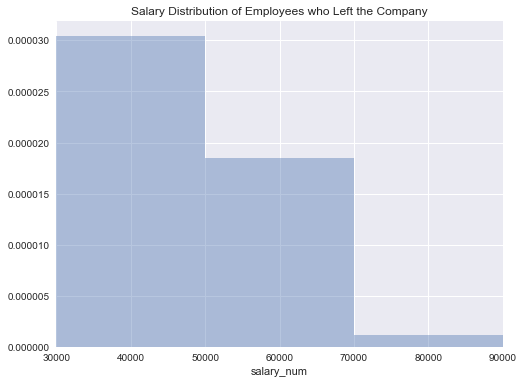

In [11]:
plt.figure(figsize=(8,6))
sns.distplot(new_emp[new_emp['left']==1]['salary_num'],kde=False,bins=3,norm_hist=True)
plt.title('Salary Distribution of Employees who Left the Company')
plt.xlim([30000,90000])
plt.show()

Most employees who left the company belonged to the lowest tranch of the income bracket.

## When are the top perfomers leaving the company?

In [12]:
top_left = emp[(emp['performance_group']=="left:Top Performer")]              

top_left['time_spend_company'].value_counts(normalize=True)

5    0.499520
4    0.352546
6    0.124880
3    0.013449
2    0.009606
Name: time_spend_company, dtype: float64

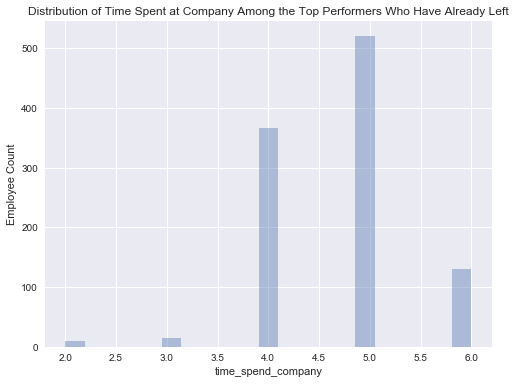

In [13]:
plt.figure(figsize=(8,6))
sns.distplot(top_left['time_spend_company'],kde=False)
plt.title('Distribution of Time Spent at Company Among the Top Performers Who Have Already Left')
plt.ylabel('Employee Count')
plt.show()

## Correlations for the top performers

In [14]:
#new_emp

In [15]:
columns = ['left','average_montly_hours', 'number_project','time_spend_company', 'promotion_last_5years']

top_emp = new_emp[new_emp['classification']=='Top Performer']
not_top_emp = new_emp[new_emp['classification']!='Top Performer']

## Top Performers Correlation Matrix

In [16]:
top_corr = top_emp.corr().loc[columns].transpose()
top_corr

,left,average_montly_hours,number_project,time_spend_company,promotion_last_5years
satisfaction_level,-0.242301,-0.255929,-0.471205,-0.077654,0.035272
last_evaluation,0.076439,-0.025307,-0.044458,0.049442,0.026130
number_project,0.537256,0.366696,1.000000,0.211145,-0.029398
average_montly_hours,0.521604,1.000000,0.366696,0.187693,0.003030
time_spend_company,0.418430,0.187693,0.211145,1.000000,0.014741
Work_accident,-0.185972,-0.086005,-0.071028,-0.082317,0.070209
left,1.000000,0.521604,0.537256,0.418430,-0.087218
promotion_last_5years,-0.087218,0.003030,-0.029398,0.014741,1.000000
std_performance,0.076439,-0.025307,-0.044458,0.049442,0.026130
performance_differential,0.076439,-0.025307,-0.044458,0.049442,0.026130


## Lower Performers Correlation Matrix

In [17]:
not_top_corr = not_top_emp.corr().loc[columns].transpose()
not_top_corr

,left,average_montly_hours,number_project,time_spend_company,promotion_last_5years
satisfaction_level,-0.450204,0.037969,-0.059429,-0.116547,0.023768
last_evaluation,-0.110281,0.334712,0.348881,0.083434,-0.001940
number_project,-0.157442,0.402044,1.000000,0.171130,0.002441
average_montly_hours,-0.085878,1.000000,0.402044,0.088013,-0.002285
time_spend_company,0.043103,0.088013,0.171130,1.000000,0.083528
Work_accident,-0.144042,0.013827,0.017399,0.028289,0.031539
left,1.000000,-0.085878,-0.157442,0.043103,-0.053722
promotion_last_5years,-0.053722,-0.002285,0.002441,0.083528,1.000000
std_performance,-0.110281,0.334712,0.348881,0.083434,-0.001940
performance_differential,-0.110281,0.334712,0.348881,0.083434,-0.001940


## Initial Insights from the Correlation Tables

### For the top performers:

- Leaving the company is correlated with: hours worked, number of projects taken, and time spent at the company
- Number of projects taken is negatively correlated with satisfaction levels
- There is no correlation between receiving a promotion in the last 5 years and working longer, or taking projects

### For the lower performers:

- Leaving the company is highly correlated with dissatisfaction levels of the employees
- As expected, average hours worked is correlated with number of projects taken on
- Also, as expected, receiving a promotion did not correlate with any of other metrics, which makes sense since we do not expect the lower performers to receive promotions

## How satisfied were the top performers who left the company?

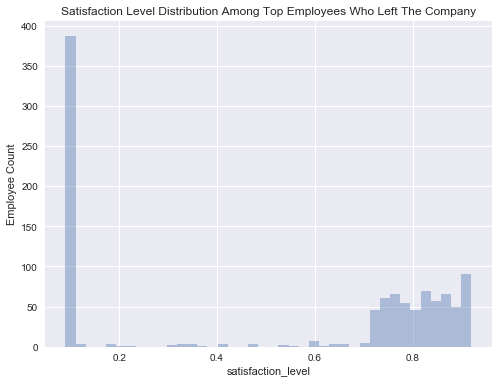

In [18]:
plt.figure(figsize=(8,6))
sns.distplot(top_left['satisfaction_level'],kde=False,bins=40)
plt.title('Satisfaction Level Distribution Among Top Employees Who Left The Company')
plt.ylabel('Employee Count')
plt.show()

## Conclusions

**Top performers** seem to be working longer hours with little appreciation. They're being assigned on more projects than the others and they're not happy about it, hence the high number of dissatisfied top performers (as shown in the figure above). Almost half of the **top performers** leave the company after 5 years. They are overworked and are unlikely to receive a promotion.

## Taking a dive into departmental stats

In [19]:
total_vc = new_emp['dept'].value_counts()
left_vc = new_emp[new_emp['left']==1]['dept'].value_counts()
#sns.countplot(x='dept',data=total_vc)
dept_df = pd.DataFrame(total_vc)
left_dept_df = pd.DataFrame(left_vc)
combined_df_dept = pd.concat([dept_df,left_dept_df],axis=1)
combined_df_dept.columns = ['total', 'left']
combined_df_dept['percentage_left'] = combined_df_dept['left'] / combined_df_dept['total']
combined_df_dept.sort('percentage_left',ascending=False)

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,total,left,percentage_left
hr,739,215,0.290934
accounting,767,204,0.265971
technical,2720,697,0.256250
support,2229,555,0.248991
sales,4140,1014,0.244928
marketing,858,203,0.236597
IT,1227,273,0.222494
product_mng,902,198,0.219512
RandD,787,121,0.153748
management,630,91,0.144444


The departments with the highest employee turnover are HR followed by Accounting. Even though the Sales department has the highest number of employees who left, they form a smaller fraction of the total number of employees in the department.

R&D and Management are the least likely to churn employees.

**Visualizing the table above in a bar plot:**

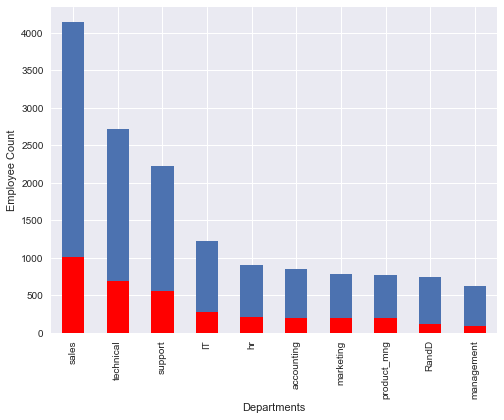

In [20]:
plt.figure(figsize=(8,6))
new_emp['dept'].value_counts().plot(kind='bar')
new_emp[new_emp['left']==1]['dept'].value_counts().plot(kind='bar', color = 'red')
plt.title =('Share of Employees who Left by Department')
plt.xlabel('Departments')
plt.ylabel('Employee Count')
plt.show()

In [21]:
new_emp_by_dept = new_emp.groupby('dept').mean()
#new_emp_by_dept

### Further Analysis On A Departmental Level

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


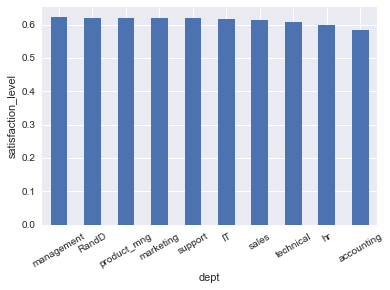

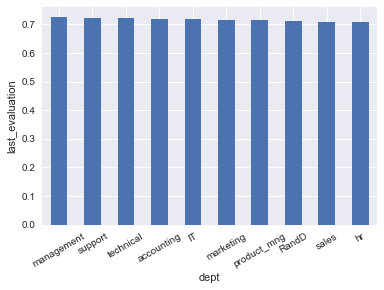

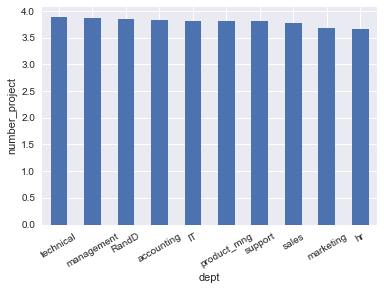

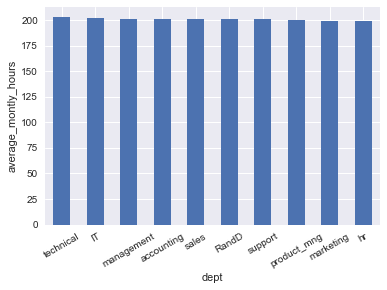

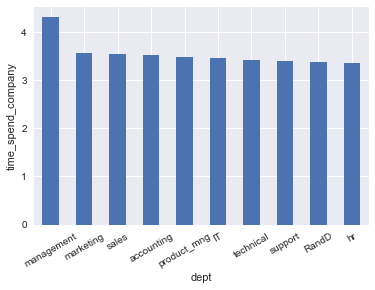

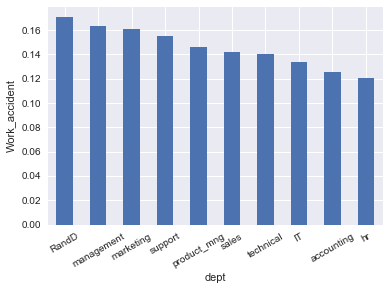

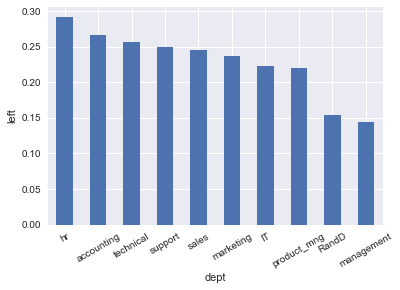

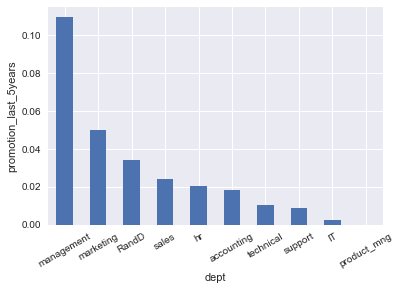

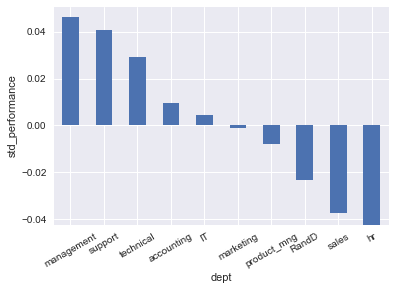

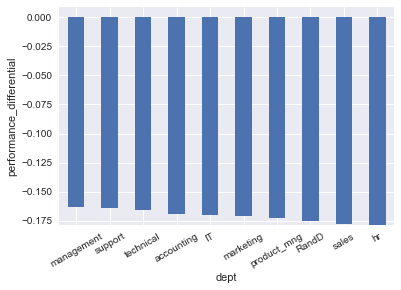

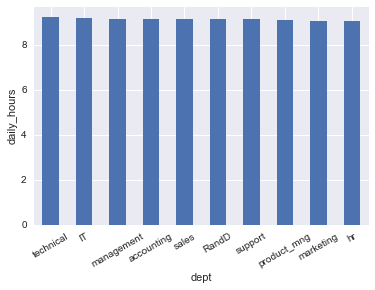

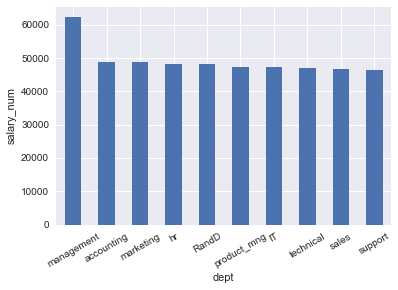

In [22]:
for col in new_emp_by_dept.columns:
    new_emp_by_dept_sorted = new_emp_by_dept.sort(col, ascending = False)
    new_emp_by_dept_sorted[col].plot(kind = 'bar')
    plt.ylabel(col)
    plt.xticks( rotation = 30)
    plt.show()

### Main Takeaways from Departmental Analysis

- Management have the **highest** satisfaction level, evaluation level, rate of promotion, and the **lowest** turnover rate. They are the third most overworked department in terms of monthly hours and the second highest in number of projects taken on. Promotion for managers usually result in a big boost in pay (salary + stock options), so it is obvious why they wouldn't leave the company.
- The Technical department seems to be the most overworking as they have the **highest** average monthly hours worked and number of projects undertaken, but they are amont the **least satisfied** employees even though their average evaluation is among the top, which would explain the high rate of technical employees leaving the company.
- Accounting and Support are amongst the most hardworking but they are among the least likely to get promoted or be satisfied, which explains the high rate of employee churn.
- It is also interesting to note that Marketing, R&D, and Sales are among the most likely to be promoted and least likely to leave, which could mean that management relies on these 3 departments more than the others, making the more hardworking people at the other departments upset with the current management style.